In [ ]:
a

# **Hackathon QuantumBlack**

# L'agriculture de demain

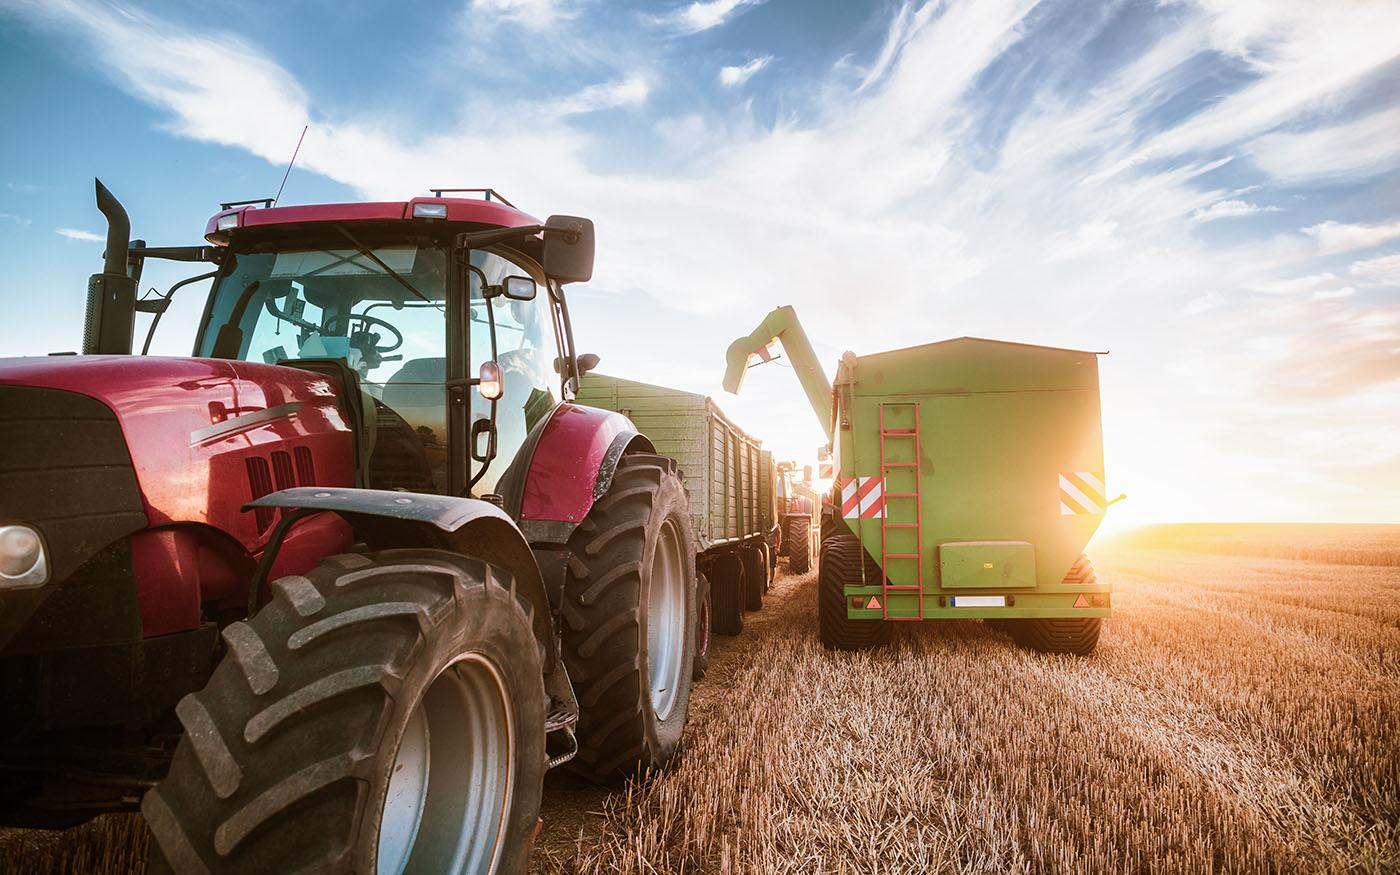

Sur une planète qui produit assez pour nourrir toute sa population, 690 millions de personnes ne mangent pas à leur faim chaque jour. Après des décennies de baisse, l’insécurité alimentaire s’est aggravée depuis 2014, sous l’effet de la multiplication des conflits armés, des phénomènes climatiques extrêmes et des crises économiques à répétition. Elle résulte également de la défaillance structurelle d’un système agricole et alimentaire mondial profondément inégalitaire.

D'où l'enjeu aujourd'hui de trouver des solutions pour lutter contre la famine dans le monde. Dans ce projet, nous nous décidons de nous attaquer au problème de stockage. 30 à 40% des réserves agricoles en Asie et en Afrique sont mal conservés et donc impropres à la consommation. Cependant, grâce à notre algorithme de deeplearning, nous sommes en mesure de détecter quelles parties du globe sont en manque de silo et nous sommes en mesure de les leur fournir.

# Import

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import pickle
import cv2

from tqdm.notebook import tqdm, tnrange
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image
import albumentations as alb
from albumentations.pytorch import ToTensorV2

In [ ]:
#import from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import du csv
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/Hackathon/x-ai_data.csv")

In [ ]:
##Ajout d'une colonne "file_path" donnant le chemin vers l'image correspondant au label
root = '/content/drive/My Drive/Hackathon'
def image_path(id):
    return f"{root}/images/{id}"
df['file_path'] = df['filename'].apply(image_path)

# def mask_path(id):
#     return f"{root}/masks/{id}"
# df['mask_path'] = df['filename'].apply(mask_path)

df.head()

,filename,class,split,file_path
0,silos_256-0-0--6-15--152-30320.png,0,validation,/content/drive/My Drive/Hackathon/images/silos...
1,silos_256-0-0--6-15--1195-31353.png,0,train,/content/drive/My Drive/Hackathon/images/silos...
2,silos_256-0-0--6-15-283-30628.png,0,train,/content/drive/My Drive/Hackathon/images/silos...
3,silos_256-0-0--6-15--339-30012.png,0,validation,/content/drive/My Drive/Hackathon/images/silos...
4,silos_256-0-0--6-15--404-30011.png,0,train,/content/drive/My Drive/Hackathon/images/silos...


In [ ]:
#train val test split
df_train = df[df['split'] == 'train']
df_val = df[df['split'] == 'validation']
df_test = df[df['split'] == 'test']
N_entries_train = len(df_train)
N_entries_val = len(df_val)
N_entries_test = len(df_test)

# Configuration

In [ ]:
#configuration
CFG  = {'img_size' : 256,
        'batch_size': 16 ,
        'augmentations' : 4,
        'test_size' : 0.2,
        'mini_train_size' : 1000,
        'mini_test_size' : 200,
        'num_workers' : 2,
       }

# Dataset

In [ ]:
#transformation des images en tensor
def DataTransform(train, gris=False):
    if(train == True):
        Transf = alb.Compose([
                        alb.Resize(CFG['img_size'], CFG['img_size']),
                        alb.HorizontalFlip(p=0.5),
                        alb.VerticalFlip(p=0.5),
                        alb.RandomRotate90(p=0.5),
                        alb.ShiftScaleRotate(rotate_limit=30),
                        alb.Normalize(),
                        ToTensorV2()],p=1.0)
    else:
        Transf = alb.Compose([
                        alb.Normalize(),
                        alb.Resize(CFG['img_size'], CFG['img_size']),
                        ToTensorV2()],p=1.0)

    return Transf

In [ ]:
#Création de la classe Dataset
class Dataset_img(Dataset):
    def __init__(self, df, transform =None):
        self.df = df
        self.name = df['file_path'].values
        self.label = df['class'].values
        # self.mask_path = df['mask_path'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.name[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.label[idx]
        # mask_path = self.mask_path[idx]
        # mask = cv2.imread(mask_path)
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)["image"]
            # mask = self.transform(image=mask)["image"]

        return {
            'image': image,
            'label': label,
            'path' : image_path,
            # 'mask' : mask
        }

In [ ]:
#creating the datasets
Dataset = Dataset_img(df, transform = DataTransform(train = False))
Dataset_train = Dataset_img(df_train, transform = DataTransform(train = False))
Dataset_val = Dataset_img(df_val, transform = DataTransform(train = False))
Dataset_test = Dataset_img(df_test, transform = DataTransform(train = False))

**Data augmentation**

In [ ]:
#data augmentation
for i in range(CFG['augmentations']-1):
    Dataset_train = torch.utils.data.ConcatDataset([Dataset_img(df_train, transform = DataTransform(train = True)),Dataset_train])

In [ ]:
#creating the dataloaders
num_workers = CFG['num_workers']
trainloader = torch.utils.data.DataLoader(Dataset_train, batch_size= CFG['batch_size'], shuffle=True, num_workers=num_workers)
valloader = torch.utils.data.DataLoader(Dataset_val, batch_size= CFG['batch_size'], shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(Dataset_test, batch_size=CFG['batch_size'], shuffle=True, num_workers=num_workers)
allloader = torch.utils.data.DataLoader(Dataset, batch_size=CFG['batch_size'], shuffle=True, num_workers=num_workers)

**Afficher les images**

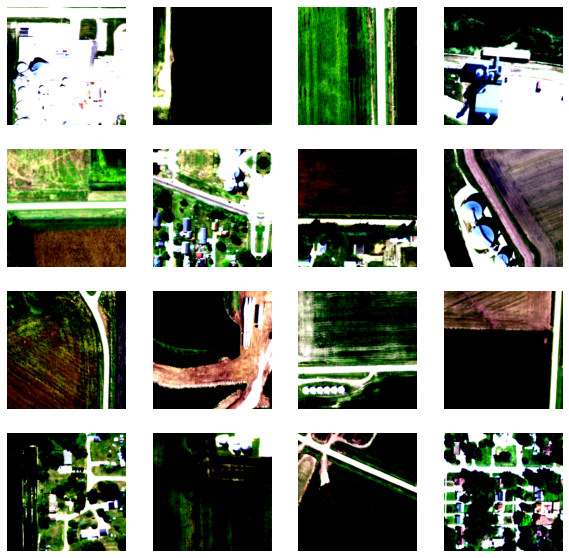

In [ ]:
#afficher les images (elles ne sont pas au bon format mais c'est juste pour verifier que le dataloader fonctionne)
plt.figure(figsize=(10,10))
tmp = next(iter(trainloader))
for i in range(16):
    plt.subplot(4,4,i +1)
    plt.imshow(torch.movedim(tmp['image'][i],0,2))
    plt.axis('off')
plt.show()

# Training

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.1 MB/s 


In [ ]:
from torchmetrics.classification import BinaryAUROC
from torchmetrics import ConfusionMatrix
from torchmetrics import F1Score

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy(net, dataloader, cuda=True, errors = False, stats=False):
    """
    Renvoie le poucentage de précision et le taux de loss
    Il peut renvoyer les erreurs de predictions avec errors = True
    Il peut aussi renvoyer d'autres statistiques avec stats = True
    """
    net.eval()
    correct = 0
    loss = 0
    total = 0
    errors_path = []
    errors_pred = []
    confmat = ConfusionMatrix(num_classes=2)
    matrix = torch.zeros(2, 2)
    auc_metric = BinaryAUROC(thresholds=None)
    auc = 0
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Processing accuracy', leave=False):
            images, labels, paths = data['image'], data['label'], data['path']

            if cuda:
                images = images.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)
            outputs = net(images)
            loss+= criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if stats:
              matrix += confmat(predicted, labels)
              auc += auc_metric(outputs[:,1], labels)*labels.size(0)
            if errors and (predicted != labels).sum().item() > 0:
              batchsize = len(labels)
              for i in range(batchsize):
                if labels[i] != predicted[i]:
                  errors_path.append(paths[i])
                  errors_pred.append(predicted[i])
    net.train()
    if stats:
      TP = matrix[0,0].item()
      FP = matrix[0,1].item()
      TN = matrix[1,1].item()
      FN = matrix[1,0].item()
      recall = TP/(TP+FN)
      precision = TP/(TP+FP)
      f1 = 2*recall*precision/(precision+recall)
      auc = auc / total
      print(f'TP = {TP}\nFP = {FP}\nTN = {TN}\nFN = {FN}\nRecall = {recall}\nPrecision = {precision}\nF1-score = {f1}\nAUC = {auc}')
    if errors:
      return (100.0 * correct / total, loss/total, errors_path, errors_pred)
    else:
      return (100.0 * correct / total, loss/total)

In [ ]:
def train(net, optimizer, train_loader, test_loader, loss,  n_epoch = 5, PATH = 'lastmodel', cuda=True):
    """
    Entraine le modele en plottant les courbes de précision et de loss et en affichant le taux de précision final.
    """
    loss_train = []
    loss_test = []
    accuracy_train = []
    accuracy_test = []

    total = 0
    for epoch in tqdm(range(n_epoch), desc='Epoch'):  # loop over the dataset multiple times
        for data in tqdm(train_loader, desc='Processing epoch', leave=False):
            inputs, labels = data['image'], data['label']

            if cuda:
                inputs = inputs.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)

        with torch.no_grad():
            precision_train, cout_train = accuracy(net, train_loader, cuda=cuda)
            precision_test, cout_test = accuracy(net, test_loader, cuda=cuda)
            loss_train.append(cout_train)
            loss_test.append(cout_test)
            accuracy_train.append(precision_train)
            accuracy_test.append(precision_test)
            print(f'Epoch {epoch}: precision_train = {precision_train}, cout_train = {cout_train}, precision_test = {precision_test}, cout_test ={cout_test}')
            # torch.save(net, PATH)
            # print(f'Saved model under {PATH}')

    x = [i for i in range(0, n_epoch)]
    plt.figure(figsize = (8,6))
    plt.subplot(2, 1, 1) #lignes, colonnes, position (sens de la lecture)
    plt.plot(x, accuracy_train, label="precision_train", c='blue', ls='--', lw=1)
    plt.plot(x, accuracy_test, label="precision_test", c='red', ls='--', lw=1)
    plt.title('Précision')
    plt.xlabel('epochs')
    plt.ylabel('Précision')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_train, label="loss_train", c='blue', ls='--', lw=1)
    plt.plot(x, loss_test, label="loss_test", c='red', ls='--', lw=1)
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    print('Finished Training')
    print(f'---Accuracy--- = {accuracy_test[-1]}')
    print(f'loss_train = {loss_train}')
    print(f'loss_test = {loss_test}')
    print(f'accuracy_train = {accuracy_train}')
    print(f'accuracy_test = {accuracy_test}')

    return net

# ResNet-18

Après avoir entrainé plusieurs modèles différents, nous avons obtenu les meilleurs résultats avec ce modèle en particulier en utilisant du transfer learning.

In [ ]:
#ResNet-18 avec du transfer learning et un classifier customisé
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Sequential(
            nn.Dropout(0.6), #pour éviter l'overfitting
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            )

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


using cuda


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/350 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/350 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0: precision_train = 94.12080057183702, cout_train = 0.01341097767839609, precision_test = 96.0, cout_test =0.012142121884971857


Processing epoch:   0%|          | 0/350 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/350 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1: precision_train = 97.1229449606862, cout_train = 0.006694295912917126, precision_test = 96.5, cout_test =0.006900056274607777


Processing epoch:   0%|          | 0/350 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/350 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2: precision_train = 98.03431022158685, cout_train = 0.0045181340619514275, precision_test = 97.0, cout_test =0.004992845915257931


Processing epoch:   0%|          | 0/350 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/350 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3: precision_train = 98.3023588277341, cout_train = 0.003583596456044349, precision_test = 97.25, cout_test =0.004753958450164646


Processing epoch:   0%|          | 0/350 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/350 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4: precision_train = 98.69549678341673, cout_train = 0.0028112329963030157, precision_test = 97.5, cout_test =0.004594290173845366


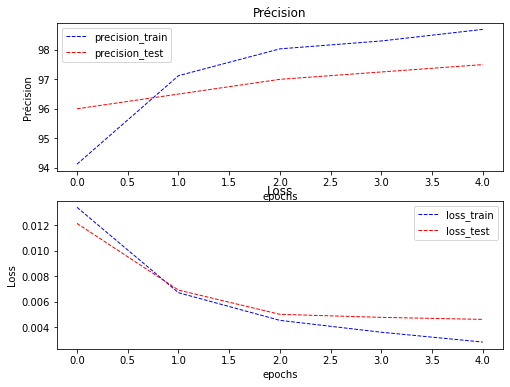

Finished Training
---Accuracy--- = 97.5
loss_train = [0.01341097767839609, 0.006694295912917126, 0.0045181340619514275, 0.003583596456044349, 0.0028112329963030157]
loss_test = [0.012142121884971857, 0.006900056274607777, 0.004992845915257931, 0.004753958450164646, 0.004594290173845366]
accuracy_train = [94.12080057183702, 97.1229449606862, 98.03431022158685, 98.3023588277341, 98.69549678341673]
accuracy_test = [96.0, 96.5, 97.0, 97.25, 97.5]


In [ ]:
net = resnet18
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-5
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
net = train(net, optimizer, trainloader, valloader, criterion, n_epoch = 5, cuda = use_cuda)

# Evaluation

In [ ]:
net = net.cpu()
a,b,errors_path,errors_pred = accuracy(net, testloader, cuda=False, errors = True, stats=True)
print(a)

Processing accuracy:   0%|          | 0/13 [00:00<?, ?it/s]

TP = 92.0
FP = 9.0
TN = 95.0
FN = 4.0
Recall = 0.9583333333333334
Precision = 0.9108910891089109
F1-score = 0.934010152284264
AUC = 0.9842738509178162
93.5


**Afficher les erreurs de prediction**

Il y a des données mal labelisées comme on peut le voir sur quelques unes de ces images

Il y a un silo selon resnet


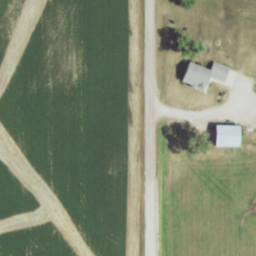



Il y a un silo selon resnet


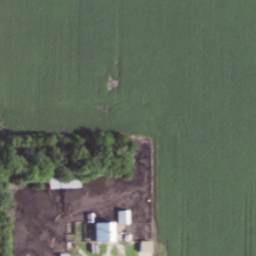



Il n'y a pas de silo selon resnet


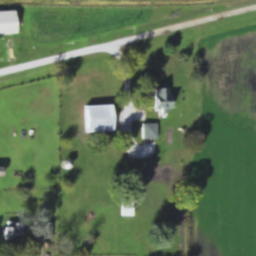



Il y a un silo selon resnet


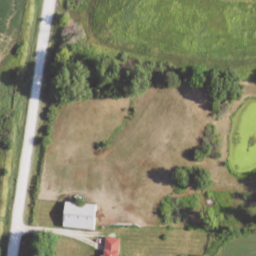



Il y a un silo selon resnet


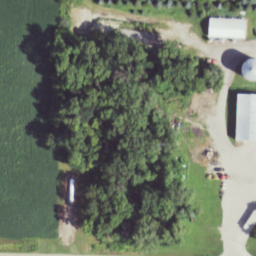



Il y a un silo selon resnet


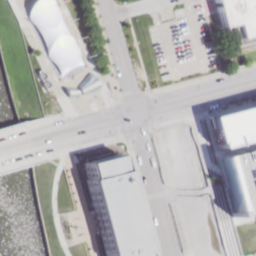



Il y a un silo selon resnet


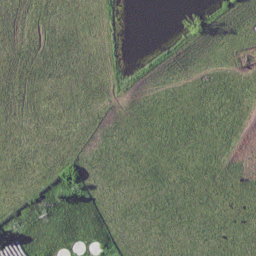



Il y a un silo selon resnet


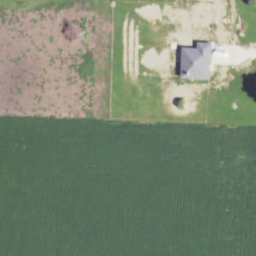



Il y a un silo selon resnet


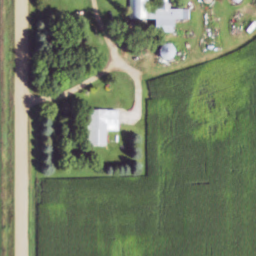



Il n'y a pas de silo selon resnet


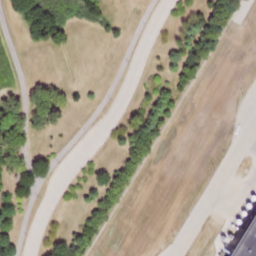



Il n'y a pas de silo selon resnet


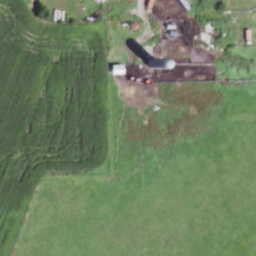



Il y a un silo selon resnet


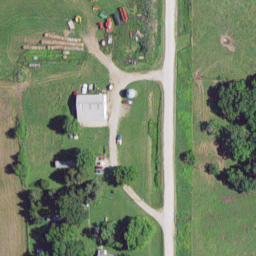



Il n'y a pas de silo selon resnet


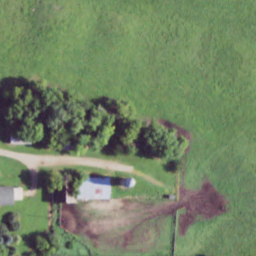

In [ ]:
from IPython.display import Image, display


for i in range(len(errors_path)):
  imageName = errors_path[i]
  if errors_pred[i].item() == 1:
    print("Il y a un silo selon resnet")
  else:
    print("Il n'y a pas de silo selon resnet")
  display(Image(filename=imageName))
  print('\n')

**Enregistrement du modèle**

In [ ]:
PATH = "/content/drive/My Drive/Hackathon/resnet_best_cpu.pt"
torch.save(net, PATH)

# Submission

In [ ]:
def model_submission(net, images_path, output_path = '/content/drive/My Drive/Hackathon/submission.csv', cuda=True):
    """
    Sauvegarder les prediction d'un modele en csv pour kaggle
    """
    net.eval()
    df_submission = pd.DataFrame(images_path, columns =['file_path'])
    df_submission['class'] = 0
    df_submission['mask_path'] = 'rien'
    Dataset_submission = Dataset_img(df_submission, transform = DataTransform(train = False))
    submissionloader = torch.utils.data.DataLoader(Dataset_submission, batch_size= 1, shuffle=False, num_workers=num_workers)
    count = 0
    with torch.no_grad():
        for data in tqdm(submissionloader, desc='Processing dataloader', leave=False):
            images = data['image']
            if cuda:
                images = images.type(torch.cuda.FloatTensor)
            output = net(images)
            _, predicted = torch.max(output.data, 1)
            df_submission.iloc[count,1] = predicted.item()
            count += 1
    df_submission.to_csv(output_path, index=False)
    print(f'Saved submission under {output_path}')

In [ ]:
def model_submission2(net, df_submission, output_path = '/content/drive/My Drive/Hackathon/equipe2.csv', cuda=True):
    """
    Sauvegarder les prediction d'un modele en csv pour kaggle
    """
    net.eval()
    df_submission.drop('split', axis=1)
    df_submission['class'] = 0
    df_submission['file_path'] = '/content/drive/My Drive/Hackathon/test_to_send/images/' + df_submission['filename']
    Dataset_submission = Dataset_img(df_submission, transform = DataTransform(train = False))
    submissionloader = torch.utils.data.DataLoader(Dataset_submission, batch_size= 1, shuffle=False, num_workers=0)
    count = 0
    with torch.no_grad():
        for data in tqdm(submissionloader, desc='Processing dataloader', leave=False):
            images = data['image']
            if cuda:
                images = images.type(torch.cuda.FloatTensor)
            output = net(images)
            _, predicted = torch.max(output.data, 1)
            df_submission.iloc[count,1] = predicted.item()
            count += 1
    df_submission.drop('file_path', axis=1)
    df_submission.to_csv(output_path, index=False)
    print(f'Saved submission under {output_path}')

In [ ]:
df_submission = pd.read_csv("/content/drive/My Drive/Hackathon/test_to_send/x-ai_test_data_without_labels.csv")
net = net.cuda()

In [ ]:
list_images = os.listdir('/content/drive/My Drive/Hackathon/test_to_send/images')

In [ ]:
list_images_final = ['/content/drive/My Drive/Hackathon/test_to_send/images/' + image_path for image_path in list_images]

In [ ]:
model_submission2(net, df_submission, output_path = '/content/drive/My Drive/Hackathon/equipe2.csv', cuda=True)

Processing dataloader:   0%|          | 0/1000 [00:00<?, ?it/s]

error: ignored

In [ ]:
# PATH = "/content/drive/My Drive/Hackathon/resnet.pt"
# net_test = torch.load(PATH, map_location=torch.device('cpu'))
# net_test.eval()
net = net.cpu()
cuda=False
output_path='/content/drive/My Drive/Hackathon/submission2.csv'
images_path = list_images_final
df_submission = pd.DataFrame(images_path, columns =['file_path'])
df_submission['class'] = 0
Dataset_submission = Dataset_img(df_submission, transform = DataTransform(train = False))
submissionloader = torch.utils.data.DataLoader(Dataset_submission, batch_size= 1, shuffle=False, num_workers=num_workers)
count = 0
with torch.no_grad():
    for data in tqdm(submissionloader, desc='Processing dataloader', leave=False):
        images = data['image']
        if cuda:
            images = images.type(torch.cuda.FloatTensor)
        output = net(images)
        _, predicted = torch.max(output.data, 1)
        df_submission.iloc[count,1] = predicted.item()
        count += 1
df_submission.to_csv(output_path, index=False)
print(f'Saved submission under {output_path}')

Processing dataloader:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved submission under /content/drive/My Drive/Hackathon/submission2.csv


In [ ]:
df_submission_final = pd.read_csv('/content/drive/My Drive/Hackathon/submission2.csv')
df_submission_final.head()

,file_path,class
0,/content/drive/My Drive/Hackathon/test_to_send...,1
1,/content/drive/My Drive/Hackathon/test_to_send...,0
2,/content/drive/My Drive/Hackathon/test_to_send...,1
3,/content/drive/My Drive/Hackathon/test_to_send...,0
4,/content/drive/My Drive/Hackathon/test_to_send...,1


In [ ]:
len(df_submission_final)

1000

In [ ]:
df_submission_final.columns = ['filename', 'class_predicted']
df_submission_final.head()

,filename,class_predicted
0,/content/drive/My Drive/Hackathon/test_to_send...,1
1,/content/drive/My Drive/Hackathon/test_to_send...,0
2,/content/drive/My Drive/Hackathon/test_to_send...,1
3,/content/drive/My Drive/Hackathon/test_to_send...,0
4,/content/drive/My Drive/Hackathon/test_to_send...,1


In [ ]:
import string

In [ ]:
'/content/drive/My Drive/Hackathon/test_to_send/images/test'[54:]

'test'

In [ ]:
def removepre(s):
  return s[54:]

In [ ]:
df_submission_final['filename'] = df_submission_final['filename'].apply(removepre)
df_submission_final.head()

,filename,class_predicted
0,silos_256-0-0--6-14-1554-29969.png,1
1,silos_256-0-0--6-14-1476-30376.png,0
2,silos_256-0-0--6-14-1461-32019.png,1
3,silos_256-0-0--6-14-1467-30553.png,0
4,silos_256-0-0--6-14-1446-30748.png,1


In [ ]:
output_path = '/content/drive/My Drive/Hackathon/equipe2.csv'
df_submission_final.to_csv(output_path, index=False)

In [ ]:
df_submission_final.head(50)

,filename,class_predicted
0,silos_256-0-0--6-14-1554-29969.png,1
1,silos_256-0-0--6-14-1476-30376.png,0
2,silos_256-0-0--6-14-1461-32019.png,1
3,silos_256-0-0--6-14-1467-30553.png,0
4,silos_256-0-0--6-14-1446-30748.png,1
5,silos_256-0-0--6-14-1430-28640.png,1
6,silos_256-0-0--6-14-1412-30793.png,0
7,silos_256-0-0--6-14-1413-31438.png,1
8,silos_256-0-0--6-14-1409-31389.png,1
9,silos_256-0-0--6-14-1401-29844.png,1


In [ ]:
df_submission_final.tail(50)

,filename,class_predicted
950,silos_256-0-0--6-16--950-31294.png,1
951,silos_256-0-0--6-16--951-30114.png,1
952,silos_256-0-0--6-16--934-29471.png,1
953,silos_256-0-0--6-16--960-31119.png,1
954,silos_256-0-0--6-16--96-28152.png,1
955,silos_256-0-0--6-16--866-30810.png,1
956,silos_256-0-0--6-16--831-31552.png,0
957,silos_256-0-0--6-16--823-31570.png,0
958,silos_256-0-0--6-16--834-31739.png,1
959,silos_256-0-0--6-16--885-29719.png,1


In [ ]:
output_path = '/content/drive/My Drive/Hackathon/equipe222.csv'
df_submission_final.to_csv(output_path, index=False)

In [ ]:
PATH = "/content/drive/My Drive/Hackathon/resnet.pt"
net_test = torch.load(PATH, map_location=torch.device('cpu'))
a,b,errors_path,errors_pred = accuracy(net_test, testloader, cuda=False, errors = True, stats=True)
print(a)

Processing accuracy:   0%|          | 0/13 [00:00<?, ?it/s]

TP = 92.0
FP = 9.0
TN = 94.0
FN = 5.0
Recall = 0.9484536082474226
Precision = 0.9108910891089109
F1-score = 0.9292929292929293
AUC = 0.9778925180435181
93.0


In [ ]:
PATH = "/content/drive/My Drive/Hackathon/resnet.pt"
net_test = torch.load(PATH, map_location=torch.device('cpu'))
torch.save(net_test.state_dict(), "/content/drive/My Drive/Hackathon/resnet_dict.pt")

# Final submission

In [ ]:
!pip install monai
from monai.networks.nets import BasicUNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 32.4 MB/s 


In [ ]:
def mask_trainer(net, dataloader):
  net.train()
  for epoch in range(1):
      for data in tqdm(dataloader, desc='Processing epoch', leave=False):
          image, mask = data['image'], data['mask']
          image, mask = image.cuda(), mask.cuda()
          optimizer.zero_grad()
          output = net(data)
          loss = criterion(output, mask)
          loss.backward()
          optimizer.step()
      print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))